In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np

In [2]:
class u(nn.Module):
  def __init__(self,num_layers = 9, layers_size = 20,output_size = 1):
    super(u,self).__init__()
    self.input_size = 2
    self.num_layers   = num_layers
    self.num_neurons  = layers_size
    self.linear = nn.ModuleList([nn.Linear(self.input_size,layers_size)])
    self.linear.extend([nn.Linear(layers_size, layers_size) for i in range(1, self.num_layers)])
    self.linear.append(nn.Linear(layers_size, output_size))
    self.tanh = nn.Tanh()
  def forward(self,x,t):
    input = torch.cat([x,t], axis = 1)
    for layer in self.linear:
      z = layer(input)
      a = self.tanh(z)
      input = a
    return input




In [3]:
model = u()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [4]:
def advection_equation(x,t,NN):
  u = NN(x,t)
  u_x = (torch.autograd.grad(u.sum(), x, create_graph=True)[0])
  u_t = (torch.autograd.grad(u.sum(), t, create_graph=True)[0])
  pde = u_t + 0.5*u_x 
  return pde



In [5]:
Nu  = 100
Nbc = np.random.randint(1,Nu,1)[0]
Nic = Nu-Nbc

Ncollocation = 10000

In [6]:
xbc = -np.ones((Nbc,1))
tbc = np.random.uniform(0,1,(Nbc,1))

xc = np.linspace(-1,1,Ncollocation)
xc = xc.reshape((len(xc),1))
tc = np.linspace(0,1,Ncollocation)
tc = tc.reshape((len(tc),1))


xic = np.random.uniform(-1,1,(Nic,1))
tic = np.zeros((Nic,1))


In [7]:
from torch.autograd import Variable

pt_x_bc = Variable(torch.from_numpy(xbc).float(), requires_grad=False).to(device)
pt_t_bc = Variable(torch.from_numpy(tbc).float(), requires_grad=False).to(device) 
exact_bc = Variable(torch.from_numpy(np.zeros((Nbc,1))).float(), requires_grad=False).to(device)

pt_x_c = Variable(torch.from_numpy(xc).float(), requires_grad=True).to(device)
pt_t_c = Variable(torch.from_numpy(tc).float(), requires_grad=True).to(device) 
exact_collocation = Variable(torch.from_numpy(np.zeros((Ncollocation,1))).float(), requires_grad=False).to(device)

pt_x_ic = Variable(torch.from_numpy(xic).float(), requires_grad=False).to(device)
pt_t_ic = Variable(torch.from_numpy(tic).float(), requires_grad=False).to(device) 
exact_ic = Variable(torch.from_numpy(-np.sin(np.pi*(xic))).float(), requires_grad=False).to(device)

In [8]:
net = u() #function approximator
net = net.to(device)  
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters(), lr =0.01)

In [9]:
for i in range(10000):
  outputofPINN_bc = net(pt_x_bc,pt_t_bc)
  outputofPINN_ic = net(pt_x_ic,pt_t_ic)
  outputofPINN_collocation = advection_equation(pt_x_c,pt_t_c,net)
  mse_bc          = mse_cost_function(outputofPINN_bc,exact_bc)
  mse_ic          = mse_cost_function(outputofPINN_ic,exact_ic)
  mse_collocation = mse_cost_function(outputofPINN_collocation,exact_collocation)

  loss = mse_bc+mse_ic+mse_collocation
  #print("Epoch: ",i," Loss:", loss.item())
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()



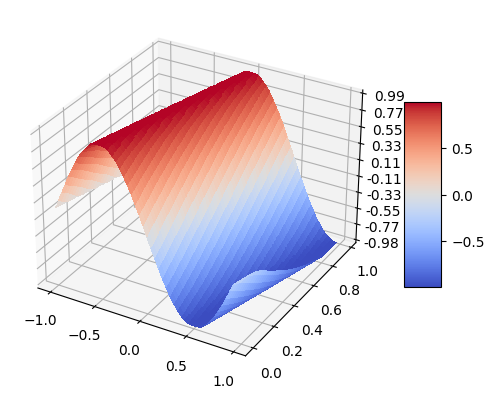

In [10]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x=np.arange(-1,1,0.02)
t=np.arange(0,1,0.02)
ms_x, ms_t = np.meshgrid(x, t)
## Just because meshgrid is used, we need to do the following adjustment
x = np.ravel(ms_x).reshape(-1,1)
t = np.ravel(ms_t).reshape(-1,1)

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
pt_u = net(pt_x,pt_t)
u=pt_u.data.cpu().numpy()
ms_u = u.reshape(ms_x.shape)

surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)
             
             

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


In [11]:
def exact_solution_advection(x,t):#phi(x-ut) where phi is the intial boundary condition
  
  arr = []
  for i in range(len(x)):
    if (x[i]- 0.5 * t[i]) <=-1:
      arr.append(0)
    else:
      arr.append(-np.sin(np.pi*(x[i] - 0.5*t[i])))
  return np.array(arr)


In [12]:
np.random.seed(42)
x_collocation = np.random.uniform(low=-1.0 , high=1.0, size=(100,1))
t_collocation = np.random.uniform(low= 0.0 , high=1.0, size=(100,1))
arr1 = exact_solution_advection(x_collocation,t_collocation)
pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=False).to(device)
pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=False).to(device)
arr2 = net(pt_x_collocation,pt_t_collocation).detach().cpu().numpy()
((arr1-arr2)**2).mean()

<ipython-input-11-c4650cb0c0e9>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(arr)


array([0.87958709])

<ipython-input-11-c4650cb0c0e9>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(arr)


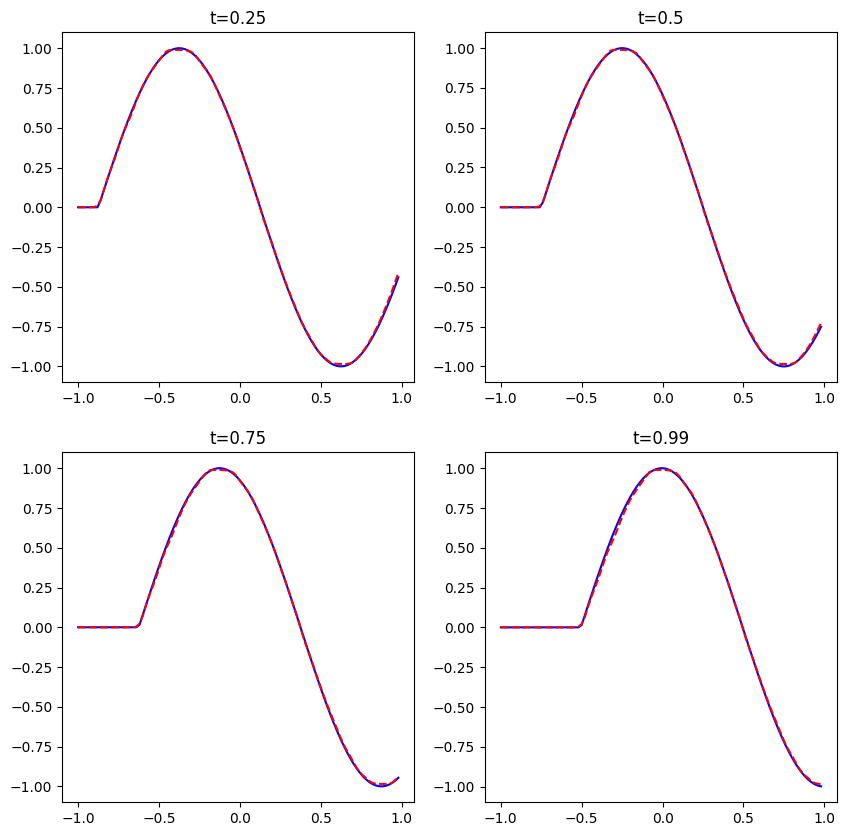

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,10))
T = [0.25,0.5,0.75,0.99] 
for i in range(len(T)):
  x = np.arange(-1,1,0.02)
  x = x.reshape((len(x),1))
  t = np.array([T[i]]*len(x))
  t = t.reshape((len(t),1))
  pt_x_collocation = Variable(torch.from_numpy(x).float(), requires_grad=False).to(device)
  pt_t_collocation = Variable(torch.from_numpy(t).float(), requires_grad=False).to(device)

  exact_solution_ad = exact_solution_advection(x,t)
  PINN_Solution_ad  = net(pt_x_collocation,pt_t_collocation).detach().cpu().numpy()
  plt.subplot(2,2,i+1)
  plt.plot(x,exact_solution_ad, color = 'blue')
  plt.plot(x,PINN_Solution_ad,color = 'red',linestyle = "--")
  plt.title(f"t={T[i]}")
plt.show()

Q2:

In [14]:
def A(x,y):
  
  t = 2.7182818284590**(-1)
  a = (1-x)*(y**3) + (x*(1+(y**3))*t) + ((1-y)*x*(torch.exp(-x) - t)) + (y*((1+x)*torch.exp(-x) - (1-x+(2*x*t))))
  #print(a)
  return a

In [15]:
def si(x,y,NN):
  return A(x,y) + (x*(1-x)*y*(1-y)*NN(x,y))


In [16]:
def pde(x,y,NN):
  u = si(x,y,NN)
  u_x  = torch.autograd.grad(u.sum(), x, create_graph = True)[0]
  u_xx = torch.autograd.grad(u_x.sum(), x, create_graph = True)[0]
  u_y  = torch.autograd.grad(u.sum(), y, create_graph = True)[0]
  u_yy = torch.autograd.grad(u_y.sum(), y, create_graph = True)[0]
  rhs  = torch.exp(-x)*(x - 2 + y**3 + 6*y)

  return u_xx+u_yy - rhs

In [17]:
#x = [0,1]
#y = [0,1]
#si(0,y) = y**3
#si(1,y) = (1 + y**3)*torch.exp([[-1]])
#si(x,0) = x*torch.exp(-x)
#si(x,1) = torch.exp(-x)*(x+1)

In [18]:
Nbc_x = 100
x_bc_x_equal_1 = np.ones((Nbc_x,1))
y_bc_x_equal_1 = np.random.uniform(0,1,(Nbc_x,1))
Nbc_y = 100
y_bc_y_equal_1 = np.ones((Nbc_y,1))
x_bc_y_equal_1 = np.random.uniform(0,1,(Nbc_y,1))

x_bc_x_equal_0 = np.zeros((Nbc_x,1))
y_bc_x_equal_0 = np.random.uniform(0,1,(Nbc_x,1))

y_bc_y_equal_0 = np.zeros((Nbc_y,1))
x_bc_y_equal_0 = np.random.uniform(0,1,(Nbc_y,1))

Ncollocation = 900
xcollocation = np.linspace(0.0,1.0,Ncollocation).reshape((Ncollocation,1))
ycollocation = np.linspace(0.0,1.0,Ncollocation).reshape((Ncollocation,1))


In [19]:
from torch.autograd import Variable

pt_x_bc_x_equal_1  = Variable(torch.from_numpy(x_bc_x_equal_1).float(), requires_grad=False).to(device)
pt_y_bc_x_equal_1  = Variable(torch.from_numpy(y_bc_x_equal_1).float(), requires_grad=False).to(device) 
exact_bc_x_equal_1 = Variable(torch.from_numpy((1+(y_bc_x_equal_1**3))*np.exp(-1)).float(), requires_grad=False).to(device)

pt_x_bc_y_equal_1  = Variable(torch.from_numpy(x_bc_y_equal_1).float(), requires_grad=False).to(device) 
pt_y_bc_y_equal_1  = Variable(torch.from_numpy(y_bc_y_equal_1).float(), requires_grad=False).to(device)
exact_bc_y_equal_1 = Variable(torch.from_numpy(np.exp(-x_bc_y_equal_1) * (x_bc_y_equal_1+1)).float(), requires_grad=False).to(device)

pt_x_bc_x_equal_0  = Variable(torch.from_numpy(x_bc_x_equal_0).float(), requires_grad=False).to(device)
pt_y_bc_x_equal_0  = Variable(torch.from_numpy(y_bc_x_equal_0).float(), requires_grad=False).to(device) 
exact_bc_x_equal_0 = Variable(torch.from_numpy(y_bc_x_equal_0**3).float(), requires_grad=False).to(device)

pt_x_bc_y_equal_0 = Variable(torch.from_numpy(x_bc_y_equal_0).float(), requires_grad=False).to(device) 
pt_y_bc_y_equal_0  = Variable(torch.from_numpy(y_bc_y_equal_0).float(), requires_grad=False).to(device)
exact_bc_y_equal_0 = Variable(torch.from_numpy(x_bc_y_equal_0*np.exp(-x_bc_y_equal_0)).float(), requires_grad=False).to(device)



pt_x_collocation = Variable(torch.from_numpy(xcollocation).float(), requires_grad=True).to(device)
pt_y_collacation = Variable(torch.from_numpy(ycollocation).float(), requires_grad=True).to(device) 
exact_collocation = Variable(torch.from_numpy(np.zeros((Ncollocation,1))).float(), requires_grad=False).to(device)


In [20]:
class ANN(nn.Module):
  def __init__(self,num_layers = 1, layers_size = 10,output_size = 1):
    super(ANN,self).__init__()
    self.input_size = 2
    self.num_layers   = num_layers
    self.num_neurons  = layers_size
    self.linear = nn.ModuleList([nn.Linear(self.input_size,layers_size)])
    self.linear.extend([nn.Linear(layers_size, layers_size) for i in range(1, self.num_layers)])
    self.linear.append(nn.Linear(layers_size, output_size))
    self.tanh = nn.Tanh()
  def forward(self,x,t):
    input = torch.cat([x,t], axis = 1)
    for layer in self.linear:
      z = layer(input)
      a = self.tanh(z)
      input = a
    return input


In [21]:
lagaris_nn = ANN() #function approximator
lagaris_nn = lagaris_nn.to(device)  
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.SGD(lagaris_nn.parameters(), lr = 0.1)

In [22]:
lagaris_nn

ANN(
  (linear): ModuleList(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (tanh): Tanh()
)

In [23]:
#lagaris approach
for i in range(10000):
  bc_x_equal_1 = si(pt_x_bc_x_equal_1,pt_y_bc_x_equal_1,lagaris_nn)
  bc_y_equal_1 = si(pt_x_bc_y_equal_1,pt_y_bc_y_equal_1,lagaris_nn)
  value_collocation = pde(pt_x_collocation,pt_y_collacation,lagaris_nn)

  mse_bc_x_equal_1 = mse_cost_function(bc_x_equal_1,exact_bc_x_equal_1)
  mse_bc_y_equal_1 = mse_cost_function(bc_y_equal_1,exact_bc_y_equal_1)
  mse_collocation  = mse_cost_function(value_collocation,exact_collocation)

  loss = mse_collocation
  #print("Loss: ",loss.item())
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if i%100 == 0:
    print("Loss: ",loss.item())



Loss:  0.0006861942238174379
Loss:  2.7434623916633427e-05
Loss:  2.269678225275129e-05
Loss:  2.21742557187099e-05
Loss:  2.1760659365099855e-05
Loss:  2.136001239705365e-05
Loss:  2.096975003951229e-05
Loss:  2.0589610358001664e-05
Loss:  2.021910040639341e-05
Loss:  1.985814560612198e-05
Loss:  1.9506302123772912e-05
Loss:  1.9163391698384658e-05
Loss:  1.882906690298114e-05
Loss:  1.8503120372770354e-05
Loss:  1.8185306544182822e-05
Loss:  1.787547444109805e-05
Loss:  1.7573105651536025e-05
Loss:  1.727833296172321e-05
Loss:  1.6990721633192152e-05
Loss:  1.6710262570995837e-05
Loss:  1.6436564692412503e-05
Loss:  1.6169502487173304e-05
Loss:  1.590891770320013e-05
Loss:  1.5654626622563228e-05
Loss:  1.5406425518449396e-05
Loss:  1.516420434199972e-05
Loss:  1.4927726624591742e-05
Loss:  1.4696769540023524e-05
Loss:  1.4471420399786439e-05
Loss:  1.4251397260522936e-05
Loss:  1.4036623724678066e-05
Loss:  1.3826766007696278e-05
Loss:  1.362190414511133e-05
Loss:  1.342169798590475

(10000, 1)


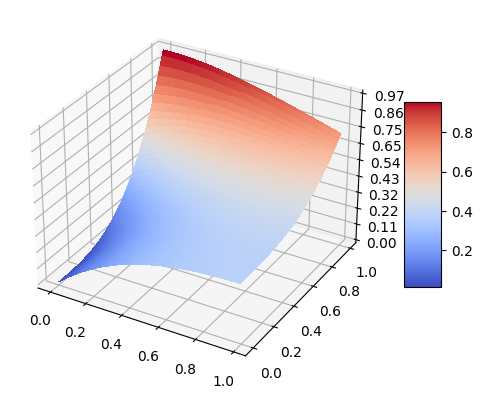

In [24]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x=np.arange(0,1,0.01)
t=np.arange(0,1,0.01)
ms_x, ms_t = np.meshgrid(x, t)
## Just because meshgrid is used, we need to do the following adjustment
x = np.ravel(ms_x).reshape(-1,1)
t = np.ravel(ms_t).reshape(-1,1)

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
pt_u = si(pt_x,pt_t,lagaris_nn)
u=pt_u.data.cpu().numpy()
print(u.shape)
ms_u = u.reshape(ms_x.shape)

surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)
             
             

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


In [25]:
def exact_solution(x,y):
  return np.exp(-x) * (x+(y**3))


In [26]:
np.random.seed(42)
x_collocation = np.random.uniform(0,1,(100,1))
t_collocation = np.random.uniform(0,1,(100,1))
arr1 = exact_solution(x_collocation,t_collocation)
pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=False).to(device)
pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=False).to(device)
arr2 = si(pt_x_collocation,pt_t_collocation,lagaris_nn).detach().cpu().numpy()

print("Average test error: ", ((arr1-arr2)**2).mean())


Average test error:  8.332718174767908e-06


In [27]:
import pandas as pd
df = pd.DataFrame([])
df["x"] = x_collocation.flatten()
df["y"] = t_collocation.flatten()
df["Exact solution"] = arr1.flatten()
df["Lagaris solution"] = arr2.flatten()
df["squared loss"] = (arr1-arr2)**2
df

,x,y,Exact solution,Lagaris solution,squared loss
0,0.374540,0.031429,0.257557,0.258116,3.128386e-07
1,0.950714,0.636410,0.467032,0.467787,5.706683e-07
2,0.731994,0.314356,0.366992,0.370959,1.573868e-05
3,0.598658,0.508571,0.401279,0.401808,2.798516e-07
4,0.156019,0.907566,0.773035,0.769909,9.772400e-06
...,...,...,...,...,...
95,0.493796,0.349210,0.327356,0.328682,1.757907e-06
96,0.522733,0.725956,0.536762,0.532829,1.547560e-05
97,0.427541,0.897110,0.749628,0.745807,1.459920e-05
98,0.025419,0.887086,0.705329,0.704503,6.808118e-07


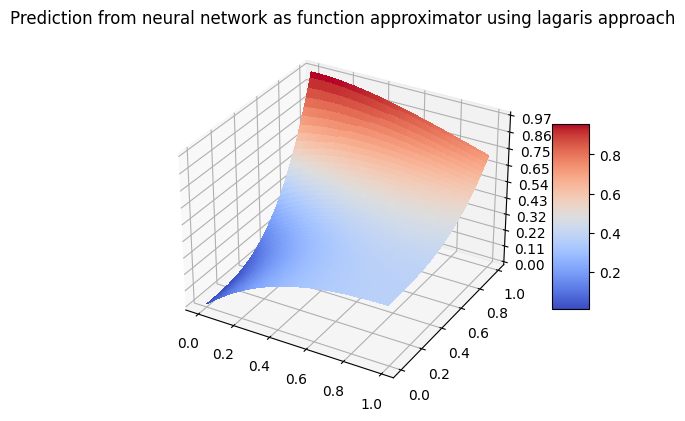

#############################################################################


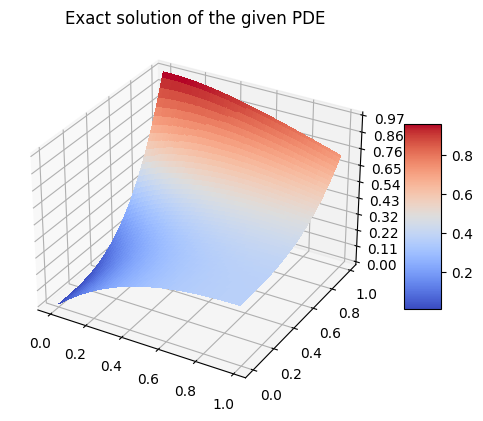

In [28]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x=np.arange(0,1,0.01)
t=np.arange(0,1,0.01)
ms_x, ms_t = np.meshgrid(x, t)
## Just because meshgrid is used, we need to do the following adjustment
x = np.ravel(ms_x).reshape(-1,1)
t = np.ravel(ms_t).reshape(-1,1)

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
pt_u = si(pt_x,pt_t,lagaris_nn)
u=pt_u.data.cpu().numpy()
#print(u.shape)
ms_u = u.reshape(ms_x.shape)

surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
plt.title("Prediction from neural network as function approximator using lagaris approach")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

print("#############################################################################")

fig = plt.figure()
ax = fig.add_subplot(projection='3d')


x=np.arange(0,1,0.01)
t=np.arange(0,1,0.01)
ms_x, ms_t = np.meshgrid(x, t)
## Just because meshgrid is used, we need to do the following adjustment
x = np.ravel(ms_x).reshape(-1,1)
t = np.ravel(ms_t).reshape(-1,1)

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
pt_u = si(pt_x,pt_t,lagaris_nn)
u    = exact_solution(x,t)
ms_u = u.reshape(ms_x.shape)

surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)
             
             

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title("Exact solution of the given PDE")
plt.show()


In [29]:
#"PINN approach"
pinn = ANN()
pinn = pinn.to(device)
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.SGD(pinn.parameters(), lr = 0.01)

In [30]:
def pde_pinn(x,y,NN):
  u    = NN(x,y) 
  u_x  = torch.autograd.grad(u.sum(), x, create_graph = True)[0]
  u_xx = torch.autograd.grad(u_x.sum(), x, create_graph = True)[0]
  u_y  = torch.autograd.grad(u.sum(), y, create_graph = True)[0]
  u_yy = torch.autograd.grad(u_y.sum(), y, create_graph = True)[0]
  rhs  = torch.exp(-x)*(x - 2 + y**3 + 6*y)

  return u_xx+u_yy - rhs

In [31]:
from torch.autograd import Variable

pt_x_bc_x_equal_1  = Variable(torch.from_numpy(x_bc_x_equal_1).float(), requires_grad=False).to(device)
pt_y_bc_x_equal_1  = Variable(torch.from_numpy(y_bc_x_equal_1).float(), requires_grad=False).to(device) 
exact_bc_x_equal_1 = Variable(torch.from_numpy((1+(y_bc_x_equal_1**3))*np.exp(-1)).float(), requires_grad=False).to(device)

pt_x_bc_y_equal_1  = Variable(torch.from_numpy(x_bc_y_equal_1).float(), requires_grad=False).to(device) 
pt_y_bc_y_equal_1  = Variable(torch.from_numpy(y_bc_y_equal_1).float(), requires_grad=False).to(device)
exact_bc_y_equal_1 = Variable(torch.from_numpy(np.exp(-x_bc_y_equal_1) * (x_bc_y_equal_1+1)).float(), requires_grad=False).to(device)

pt_x_bc_x_equal_0  = Variable(torch.from_numpy(x_bc_x_equal_0).float(), requires_grad=False).to(device)
pt_y_bc_x_equal_0  = Variable(torch.from_numpy(y_bc_x_equal_0).float(), requires_grad=False).to(device) 
exact_bc_x_equal_0 = Variable(torch.from_numpy(y_bc_x_equal_0**3).float(), requires_grad=False).to(device)

pt_x_bc_y_equal_0 = Variable(torch.from_numpy(x_bc_y_equal_0).float(), requires_grad=False).to(device) 
pt_y_bc_y_equal_0  = Variable(torch.from_numpy(y_bc_y_equal_0).float(), requires_grad=False).to(device)
exact_bc_y_equal_0 = Variable(torch.from_numpy(x_bc_y_equal_0*np.exp(-x_bc_y_equal_0)).float(), requires_grad=False).to(device)



pt_x_collocation = Variable(torch.from_numpy(xcollocation).float(), requires_grad=True).to(device)
pt_y_collacation = Variable(torch.from_numpy(ycollocation).float(), requires_grad=True).to(device) 
exact_collocation = Variable(torch.from_numpy(np.zeros((Ncollocation,1))).float(), requires_grad=False).to(device)


In [32]:
#lagaris approach
for i in range(int(1e5)):
  bc_x_equal_1 = pinn(pt_x_bc_x_equal_1,pt_y_bc_x_equal_1)
  bc_y_equal_1 = pinn(pt_x_bc_y_equal_1,pt_y_bc_y_equal_1)
  bc_x_equal_0 = pinn(pt_x_bc_x_equal_0,pt_y_bc_x_equal_0)
  bc_y_equal_0 = pinn(pt_x_bc_y_equal_0,pt_y_bc_y_equal_0)
  value_collocation = pde_pinn(pt_x_collocation,pt_y_collacation,pinn)

  mse_bc_x_equal_1 = mse_cost_function(bc_x_equal_1,exact_bc_x_equal_1)
  mse_bc_y_equal_1 = mse_cost_function(bc_y_equal_1,exact_bc_y_equal_1)
  mse_bc_x_equal_0 = mse_cost_function(bc_x_equal_0,exact_bc_x_equal_0)
  mse_bc_y_equal_0 = mse_cost_function(bc_y_equal_0,exact_bc_y_equal_0)
  mse_collocation  = mse_cost_function(value_collocation,exact_collocation)

  loss = mse_collocation + mse_bc_x_equal_1+mse_bc_y_equal_1+mse_bc_x_equal_0+mse_bc_y_equal_0
  #print("Loss: ",loss.item())
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if i%100 == 0:
    print("Loss: ",loss.item())



Loss:  2.895106554031372
Loss:  1.8687489032745361
Loss:  0.5172545313835144
Loss:  0.30826109647750854
Loss:  0.24469241499900818
Loss:  0.21180360019207
Loss:  0.20460455119609833
Loss:  0.19884845614433289
Loss:  0.19311165809631348
Loss:  0.18789297342300415
Loss:  0.18339484930038452
Loss:  0.17962685227394104
Loss:  0.1765403002500534
Loss:  0.1740681529045105
Loss:  0.17213161289691925
Loss:  0.17064324021339417
Loss:  0.16951528191566467
Loss:  0.16866564750671387
Loss:  0.1680213212966919
Loss:  0.16752280294895172
Loss:  0.1671253740787506
Loss:  0.16679427027702332
Loss:  0.16650822758674622
Loss:  0.1662515550851822
Loss:  0.16601431369781494
Loss:  0.16579049825668335
Loss:  0.1655764877796173
Loss:  0.16537193953990936
Loss:  0.1651735007762909
Loss:  0.1649799942970276
Loss:  0.16479186713695526
Loss:  0.16460612416267395
Loss:  0.16442134976387024
Loss:  0.16423527896404266
Loss:  0.16404341161251068
Loss:  0.1638452708721161
Loss:  0.1636354774236679
Loss:  0.163409844

In [34]:
np.random.seed(42)
x_collocation = np.random.uniform(0,1,(100,1))
t_collocation = np.random.uniform(0,1,(100,1))
arr1 = exact_solution(x_collocation,t_collocation)
pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=False).to(device)
pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=False).to(device)
arr2 = pinn(pt_x_collocation,pt_t_collocation).detach().cpu().numpy()

print("Average test error: ", ((arr1-arr2)**2).mean())


Average test error:  0.0010002263592401393


In [35]:
import pandas as pd
df_raissi = pd.DataFrame([])
df_raissi["x"] = x_collocation.flatten()
df_raissi["y"] = t_collocation.flatten()
df_raissi["Exact solution"] = arr1.flatten()
df_raissi["Lagaris solution"] = arr2.flatten()
df_raissi["squared loss"] = (arr1-arr2)**2
df_raissi

,x,y,Exact solution,Lagaris solution,squared loss
0,0.374540,0.031429,0.257557,0.267230,0.000094
1,0.950714,0.636410,0.467032,0.478008,0.000120
2,0.731994,0.314356,0.366992,0.345718,0.000453
3,0.598658,0.508571,0.401279,0.403229,0.000004
4,0.156019,0.907566,0.773035,0.830038,0.003249
...,...,...,...,...,...
95,0.493796,0.349210,0.327356,0.320541,0.000046
96,0.522733,0.725956,0.536762,0.565736,0.000839
97,0.427541,0.897110,0.749628,0.779040,0.000865
98,0.025419,0.887086,0.705329,0.793203,0.007722


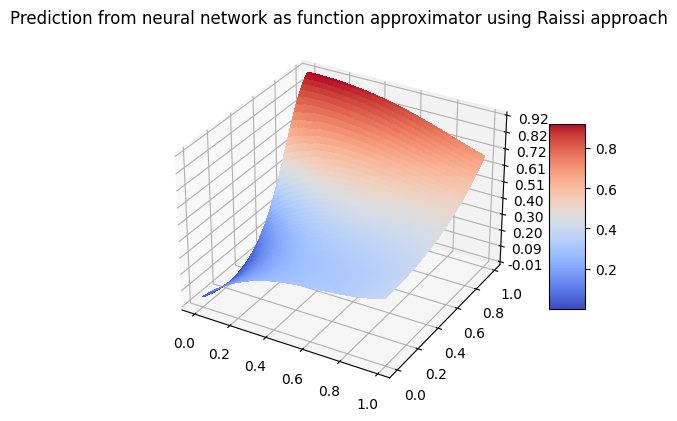

#############################################################################


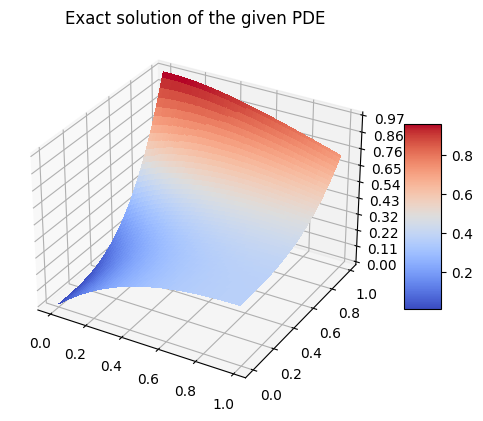

In [33]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x=np.arange(0,1,0.01)
t=np.arange(0,1,0.01)
ms_x, ms_t = np.meshgrid(x, t)
## Just because meshgrid is used, we need to do the following adjustment
x = np.ravel(ms_x).reshape(-1,1)
t = np.ravel(ms_t).reshape(-1,1)

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
pt_u = pinn(pt_x,pt_t)
u=pt_u.data.cpu().numpy()
#print(u.shape)
ms_u = u.reshape(ms_x.shape)

surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
plt.title("Prediction from neural network as function approximator using Raissi approach")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

print("#############################################################################")

fig = plt.figure()
ax = fig.add_subplot(projection='3d')


x=np.arange(0,1,0.01)
t=np.arange(0,1,0.01)
ms_x, ms_t = np.meshgrid(x, t)
## Just because meshgrid is used, we need to do the following adjustment
x = np.ravel(ms_x).reshape(-1,1)
t = np.ravel(ms_t).reshape(-1,1)

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
u    = exact_solution(x,t)
ms_u = u.reshape(ms_x.shape)

surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)
             
             

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title("Exact solution of the given PDE")
plt.show()


**Observations:**

1. Lagaris approach converged much faster than Raissi approach
2. Althogh Raissi approach is converging to the optimal approximation, the convergence is much slower (compared to Lagaris approach), for the same number of given samples, as it has to satisfy 5 boundary/initial conditions and respect the PDE, incomparision to Lagaris approach where it has to only satify the PDE.

3. The difficulty in lagaris approach is that, it is not always easy to express the function so as to satisfy the boundary conditions exactly. For example it is not very easy to write the equation to satisfy the initial condition for higher dimensional problems like (Y0 + (t*NN(x,t)))

4. In summary, Raissis approach is much simpler to implement and converges to the optimal approximation after sufficient number of epochs. Whereas Lagaris approach is very strict on the initial and boundary conditions and it is always not easy to get the expression of the Lagaris approach. But the convergence of Lagaris approach is much faster compared to the Raissi approach. One more advantange of Raissi approach is that, it is very easy to include any measured data.

5. Convergence in Lagaris approach far better (more than 10 times faster) compared to Raissi's approach, which is evident from the value of loss after end of training.

**Raissi approach:**

**Training Loss:**  0.007165840361267328

**Test Loss:** 0.0010002263592401393 

**Epochs:** 100000


**Lagaris approach:**

**Loss:**  6.607873729080893e-06  

**Test Loss:** 8.332718174767908e-06

**Epochs:** 10000

